In [2]:
import os #for using operating system-dependent functionality
import numpy as np # for numerical computations
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt #for creating visualizations 
import seaborn as sns #for high-level interfaces, built on-top plt
import warnings
warnings.filterwarnings(action="ignore")

import librosa #for audio analysis
import librosa.display #for displaying audio data

from sklearn.preprocessing import MinMaxScaler #for feature scaling
from tqdm import tqdm, notebook,trange #functions/classes for displaying progress bars during iterations
from sklearn.linear_model import LogisticRegression # for logistic regression modeling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from keras.preprocessing import image
from keras import backend as K #pre-trained deep learning models for computer vision tasks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential #to build sequential neural network models
from keras.layers import Flatten,BatchNormalization #DL layers
from keras.layers import Dense,Dropout
from keras.optimizers import Adam # optimizer used in training
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import plotly as px #for creating interactive visualizations
import plotly.graph_objects as go #for creating graph objects

from pylab import rcParams #to customize graph figure
rcParams['figure.figsize'] = 15,6
plt.style.use('fivethirtyeight')

In [3]:
#importing all 380,000 data entries to one file for treatment
file_paths = [
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-invalid.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-test.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-test.csv",
]
dfs = []
for i in file_paths:
    df = pd.read_csv(i)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

output_file_path = os.path.join("D:/AMINA/PFE24/application", "data.csv")
df.to_csv(output_file_path, index=False)

df.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380368 entries, 0 to 380367
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    380368 non-null  object 
 1   text        380366 non-null  object 
 2   up_votes    380368 non-null  int64  
 3   down_votes  380368 non-null  int64  
 4   age         149021 non-null  object 
 5   gender      149281 non-null  object 
 6   accent      129234 non-null  object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 23.2+ MB


In [29]:
df = df.dropna(subset=['age'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149021 entries, 5 to 380366
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    149021 non-null  object 
 1   text        149020 non-null  object 
 2   up_votes    149021 non-null  int64  
 3   down_votes  149021 non-null  int64  
 4   age         149021 non-null  object 
 5   gender      148487 non-null  object 
 6   accent      126628 non-null  object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 10.2+ MB


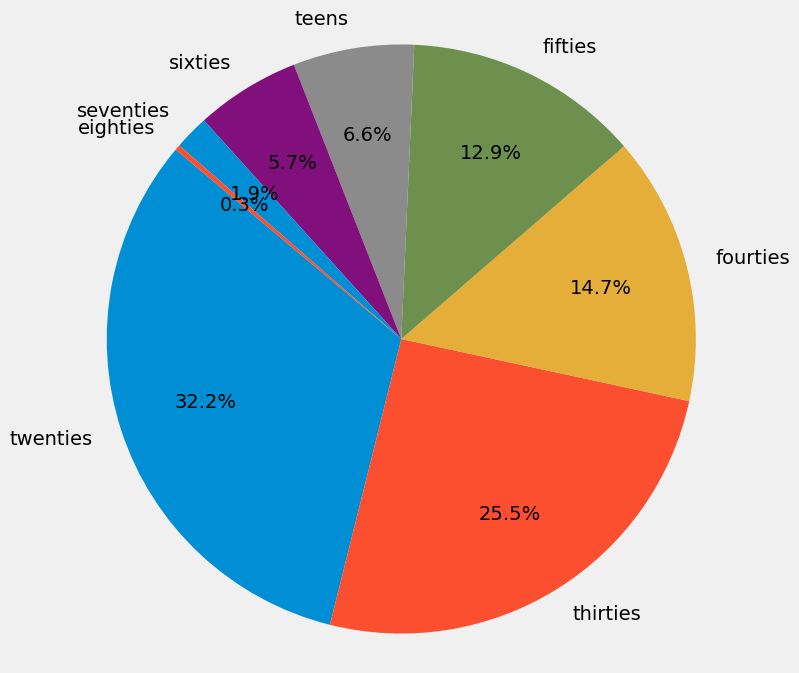

In [25]:
plt.figure(figsize=(8, 8))
df['age'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, pctdistance=0.7)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.ylabel('')  # Remove y-axis label
plt.show()

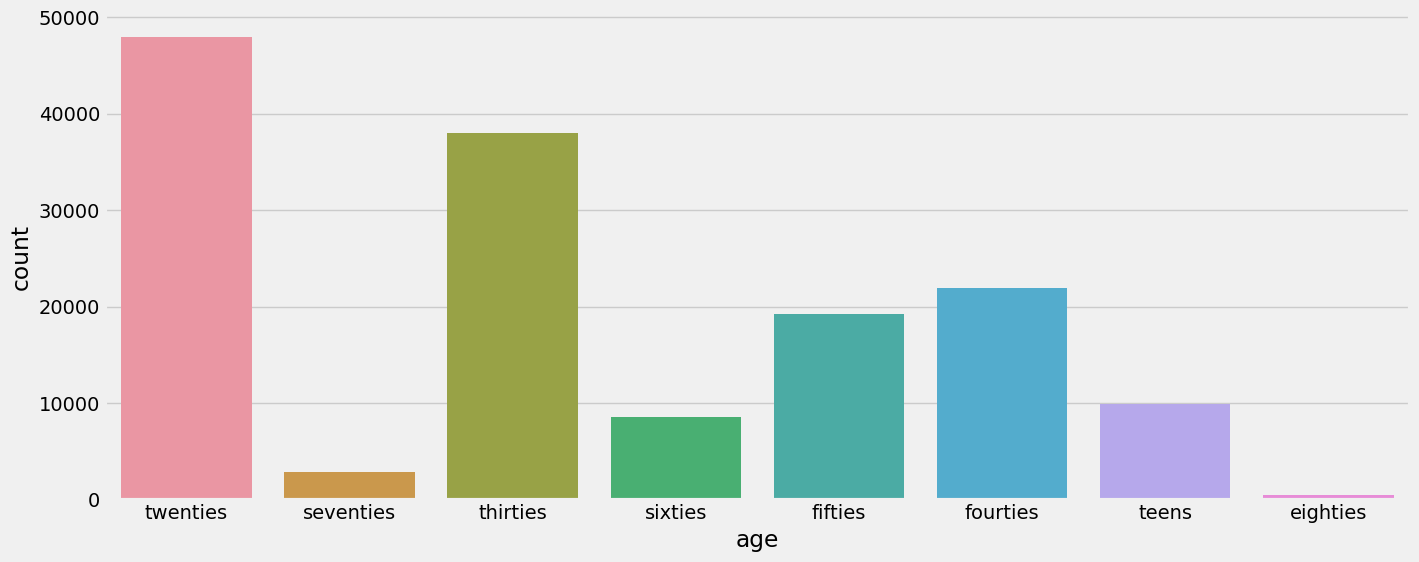

In [26]:
sns.countplot(x=df.age)
plt.show()

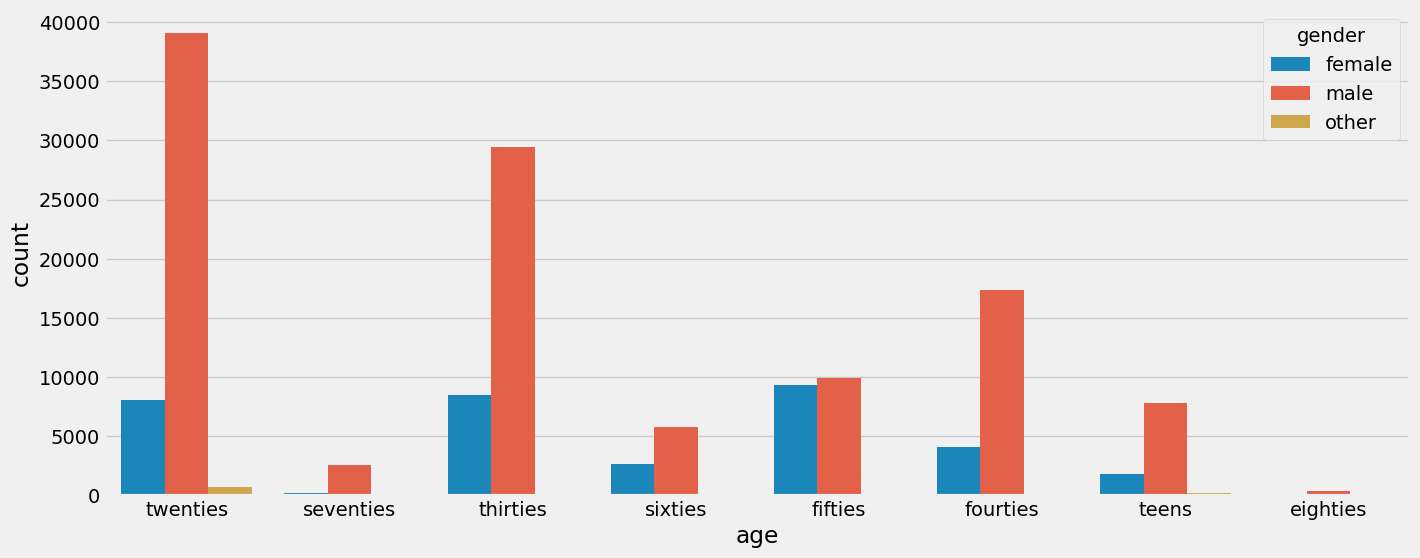

In [36]:
sns.countplot(x='age', hue='gender', data=df)
plt.show()

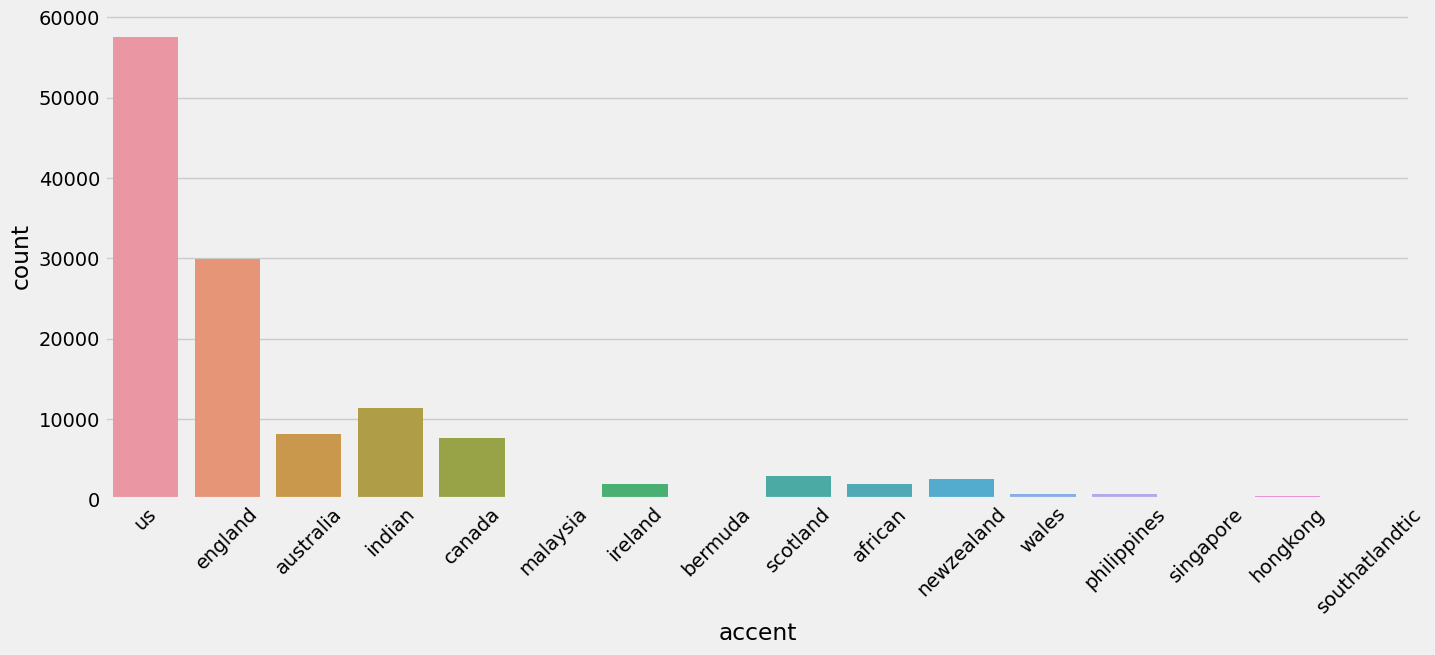

In [39]:
sns.countplot(x=df.accent)
plt.xticks(rotation=45)
plt.show()

In [40]:
#DATA CLEANING
df = df[["filename","age","gender","accent"]]
df = df.dropna(subset=['gender'])
df = df.dropna(subset=['accent'])
cleanup_nums = {"age": {"teens":1,"twenties":2,"thirties":3,"fourties":4,"fifties":5,"sixties":6,"seventies":7,"eighties":8}}
df = df.replace(cleanup_nums)
df.head(2)

,filename,age,gender,accent
5,cv-valid-train/sample-000005.mp3,2,female,us
8,cv-valid-train/sample-000008.mp3,7,male,us


In [41]:
#AUDIO PROCESSING
#first: iterating through the audio folders and comparing with df["filename"] values
folder_paths = [
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-test/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-dev/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-train/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-test/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-dev/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-invalid/"
]

for folder_path in folder_paths:
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Check if the filename starts with the folder name
        if row["filename"].startswith(folder_path.split("/")[-2]):
            # Concatenate the folder path with the filename
            df.at[index, "filename"] = folder_path + row["filename"]
# Reset the index because it was ruined after combining the 7 csv and deleting multiple lin
df.reset_index(drop=True, inplace=True)
df.head(2)

,filename,age,gender,accent
0,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,2,female,us
1,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,7,male,us


In [ ]:
# Save cleaned and manipulated data to CSV
data_csv_path = "D:/AMINA/PFE24/application/data.csv"
#df.to_csv(data_csv_path, index=False)

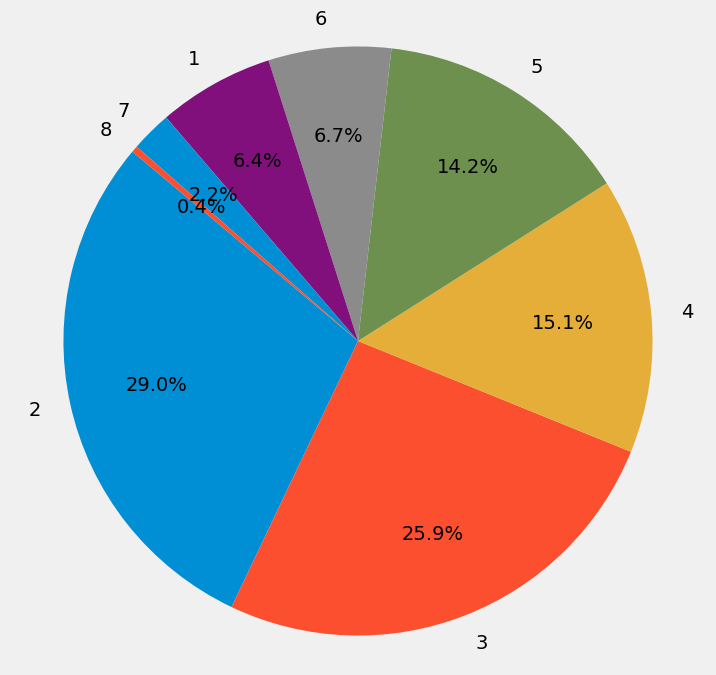

In [43]:
plt.figure(figsize=(8, 8))
df['age'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, pctdistance=0.7)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.ylabel('')  # Remove y-axis label
plt.show()

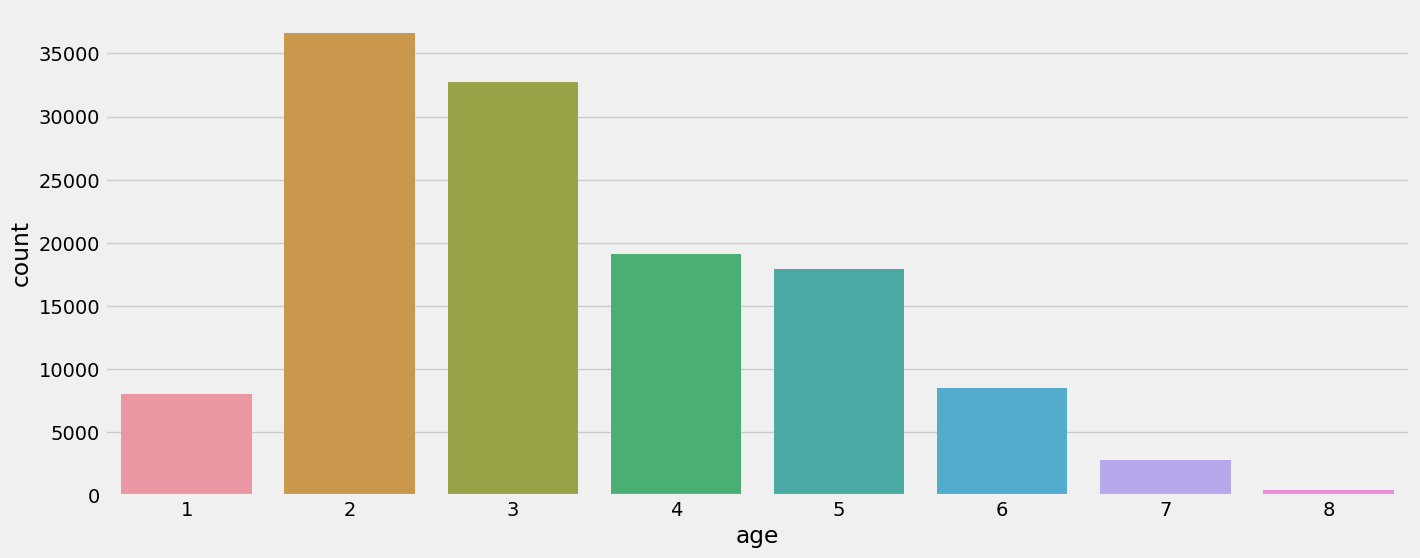

In [44]:
sns.countplot(x=df.age)
plt.show()

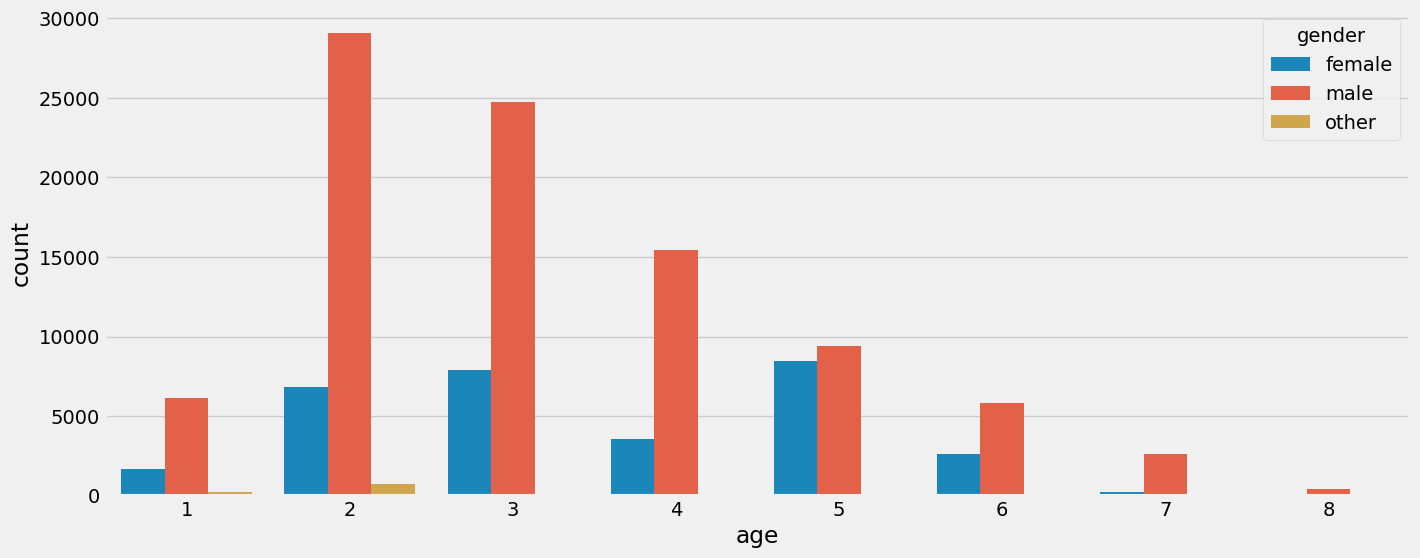

In [45]:
sns.countplot(x='age', hue='gender', data=df)
plt.show()

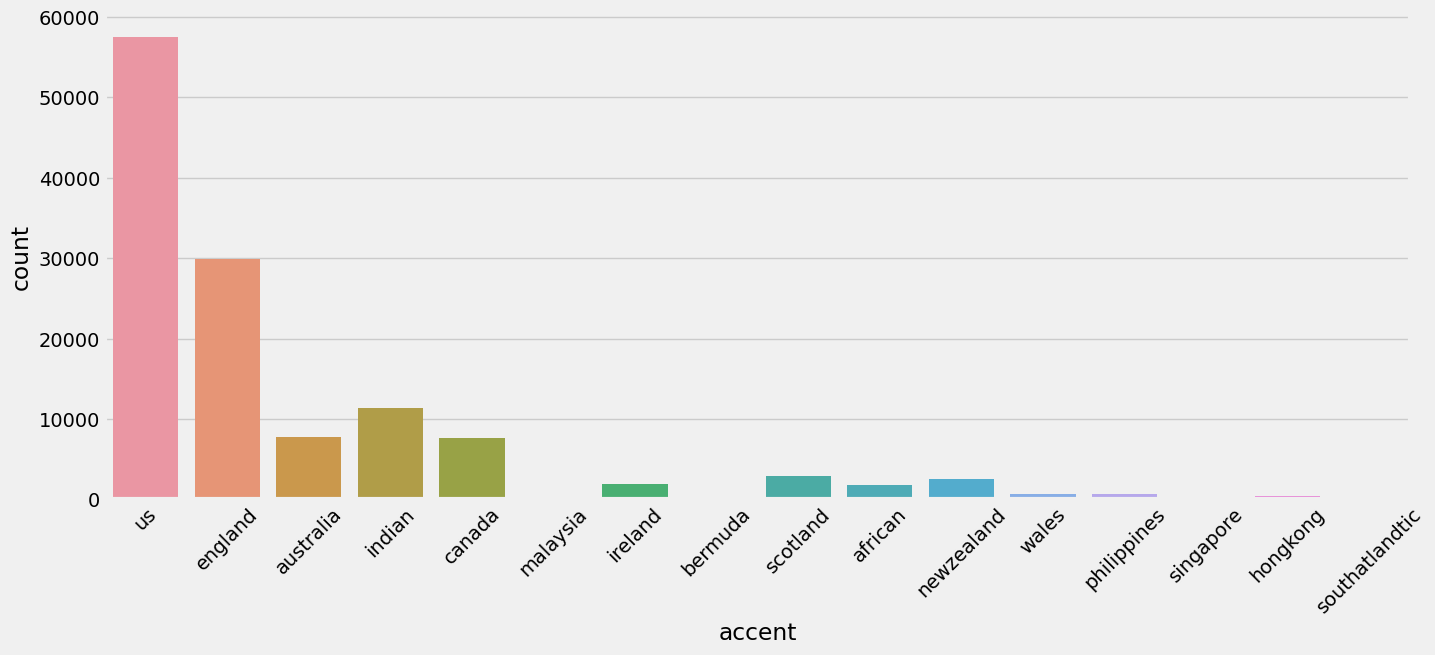

In [46]:
sns.countplot(x=df.accent)
plt.xticks(rotation=45)
plt.show()